In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn']

In [3]:
binding_df_full = pd.read_csv('data/GRB2-SH3.binding.csv')
binding_df = binding_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
abundance_df_full = pd.read_csv('data/GRB2-SH3.abundance.csv')
abundance_df = abundance_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

In [5]:
data_df = abundance_df.copy()
y_cols = data_df.columns[1:] 

In [6]:
X = data_df['aa_seq']
y = data_df[y_cols]

In [7]:
y

,count_e1_s0,count_e1_s1
0,47.0,99
1,30.0,28
2,68.0,3
3,34.0,0
4,371.0,15
...,...,...
59723,117.0,17
59724,43.0,4
59725,92.0,3
59726,290.0,21


In [8]:
# set positional argumnets for gpmap function
L = len(data_df['aa_seq'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=57, Y=2


In [9]:
gpmap_abundance_DM = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)
gpmap_abundance_EE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

#gpmap_abundance = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-12-02 14:40:02.640502: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [11]:
def model_local(gpmap, 
                mp,
                x_train,
                y_train):
    
    model = mavenn.Model2(gpmap=gpmap,
                          mp_list=[mp])
    
    # Set training data
    model.set_data(x=x_train.values,
                   y_list=[y_train.values],
                   shuffle=True)
    
    return model
    

In [12]:
mp_DM = mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                               Y=Y,
                                                               K=50,
                                                               eta=1e-5,)


mp_EE = mavenn.measurement_process_layers.ExponentialEnrichmentMP(Y=Y,
                                                                  t_y=[0,1],
                                                                  eta=1e-5,
                                                                  info_for_layers_dict={'H_y_norm':0})


In [13]:
model_abundance_DM = model_local(gpmap_abundance_DM,mp_DM, x_train, y_train)
model_abundance_EE = model_local(gpmap_abundance_EE,mp_EE, x_train, y_train)

N = 53,755 observations set as training data.
Using 20.3% for validation.
Data shuffled.
Time to set data: 3.3 sec.
N = 53,755 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 2.71 sec.


In [14]:
# # Set training data
# model.set_data(x=x_train.values,
#                y_list=[y_train.values],
#                shuffle=True)


In [15]:
# from tensorflow.keras.utils import plot_model
# plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='lehner.png')

In [16]:

# Fit model to data
model_abundance_DM.fit(learning_rate=.0005,
                     epochs=300,
                     batch_size=300,
                     try_tqdm = False,
                     early_stopping=False,
                     verbose=False,
                     early_stopping_patience=10,
                     linear_initialization=False)

model_abundance_EE.fit(learning_rate=.0005,
                     epochs=300,
                     batch_size=300,
                     try_tqdm = False,
                     early_stopping=False,
                     verbose=False,
                     early_stopping_patience=10,
                     linear_initialization=False)

Training time: 251.0 seconds
Training time: 127.7 seconds


On test data:


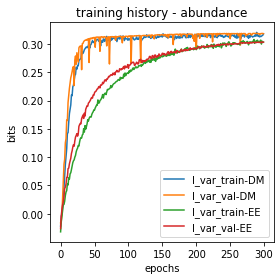

In [17]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_abundance_DM.history['I_var']
val_I_var_hist = model_abundance_DM.history['val_I_var']

fig, ax = plt.subplots(figsize=[4,4])

ax.plot(I_var_hist, label='I_var_train-DM')
ax.plot(val_I_var_hist, label='I_var_val-DM')
#ax.set_xscale('log')
ax.set_title('training history - abundance')

I_var_hist = model_abundance_EE.history['I_var']
val_I_var_hist = model_abundance_EE.history['val_I_var']

ax.plot(I_var_hist, label='I_var_train-EE')
ax.plot(val_I_var_hist, label='I_var_val-EE')

ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/training_history_abundance.png',dpi=200,bbox_inches='tight')


In [18]:
phi_DM = gpmap_abundance_DM.x_to_phi(x_test)
phi_EE = gpmap_abundance_EE.x_to_phi(x_test)

In [19]:
theta_lc_DM = gpmap_abundance_DM.get_theta(model_abundance_DM,gauge='consensus')['theta_lc']
theta_lc_EE = gpmap_abundance_EE.get_theta(model_abundance_EE,gauge='consensus')['theta_lc']
theta_lc_consensus_EE_df = pd.DataFrame(theta_lc_EE,columns=alphabet)
theta_lc_consensus_DM_df = pd.DataFrame(theta_lc_DM,columns=alphabet)
# theta_raw_df = pd.DataFrame(theta,columns=alphabet)

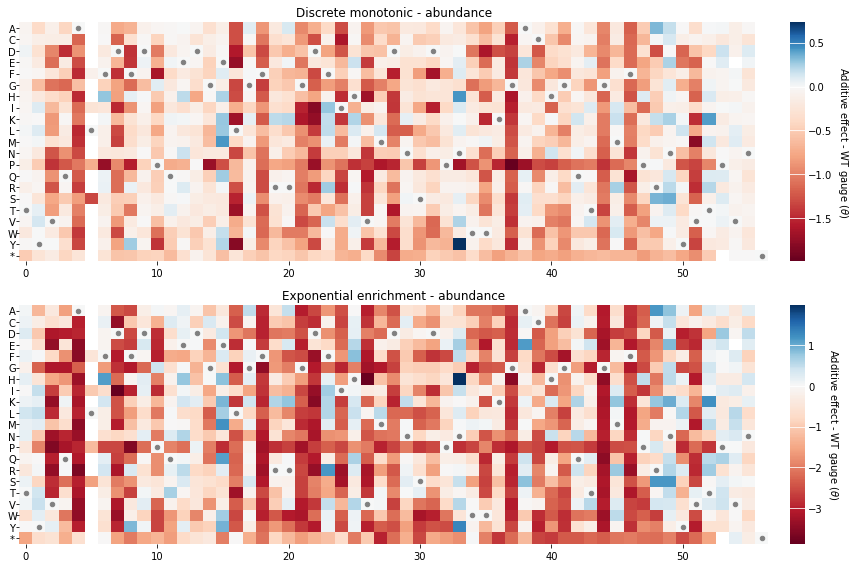

In [20]:

# # Create fig and ax objects
fig, axs = plt.subplots(2,1, figsize=[12,8])

ax = axs[0]
# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=theta_lc_DM,
                        alphabet=alphabet,
                        seq=model_abundance_DM.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Discrete monotonic - abundance')

ax = axs[1]
# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=theta_lc_EE,
                        alphabet=alphabet,
                        seq=model_abundance_EE.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Exponential enrichment - abundance')


fig.tight_layout()
fig.savefig('plots/GRB2_SH3/GP_map_abundance.png',dpi=300,bbox_inches='tight')

Text(0, 0.5, 'Theta exponential enrichment')

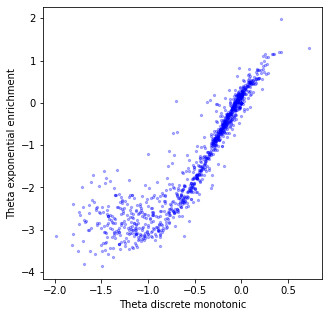

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(theta_lc_DM.ravel(),theta_lc_EE.ravel(),c='blue',s=5,alpha=0.3)
plt.xlabel('Theta discrete monotonic')
plt.ylabel('Theta exponential enrichment')

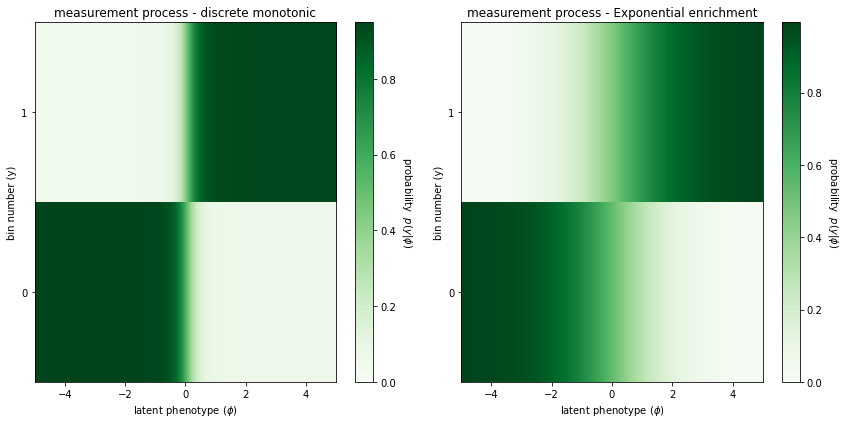

In [22]:
# Create grid in phi space
phi_lim = [-5, 5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_DM.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,6])

ax = axs[0]
# Right panel: draw measurement process as heatmap

measurement_process = mp_DM.p_of_y_given_phi(y_all, phi_grid)
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - discrete monotonic')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

ax = axs[1]
# Right panel: draw measurement process as heatmap

measurement_process = mp_EE.p_of_y_given_phi(y_all, phi_grid)
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - Exponential enrichment')
cb = plt.colorbar(im,ax=ax)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")


fig.tight_layout()
fig.savefig('plots/GRB2_SH3/lehner_measurment_prcoess_abundance.png',dpi=300,bbox_inches='tight')


In [23]:
stop

NameError: name 'stop' is not defined

In [24]:
data_df_GE = abundance_df_full[['aa_seq','fitness']].copy()

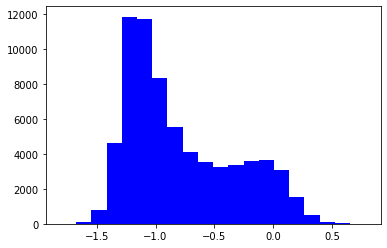

In [25]:
plt.hist(data_df_GE['fitness'],bins=20,color='blue')
plt.show()

In [26]:
gpmapGE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)
mp_GE = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=50,
                                                           monotonic=True,
                                                           ge_heteroskedasticity_order=2,
                                                           ge_noise_model_type='Gaussian')

In [27]:
data_df_GE

,aa_seq,fitness
0,NYVQALFDFRPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,0.014463
1,NYVQALFDFDTQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.161291
2,NYVQALFDFDPQEDEELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.359899
3,NYVQALFDFDPQEDGELGRRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.348834
4,NYVQALFDFDPQEDGELGGRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.164175
...,...,...
69739,MYVQALFVFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.923700
69740,MYVQALF*FDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.104500
69741,MYVQALFCFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.097747
69742,MYVQYLFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-1.181016


In [28]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train_GE, x_test_GE, y_train_GE, y_test_GE = train_test_split(data_df_GE['aa_seq'].values, 
                                                                data_df_GE['fitness'].values, test_size=0.1)

In [29]:
model_GE = mavenn.Model2(gpmap=gpmapGE,
                      mp_list=[mp_GE])

# Set training data
model_GE.set_data(x=x_train_GE,
               #y_list=[data_df['y'].values.reshape(-1,1)],
               y_list=[y_train_GE.reshape(-1,1)],
               shuffle=False)

N = 62,769 observations set as training data.
Using 19.8% for validation.
Time to set data: 2.03 sec.


In [30]:
# Fit model to data
history = model_GE.fit(learning_rate=.0005,
                    epochs=150,
                    batch_size=300,
                    try_tqdm=False,
                    early_stopping=False,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/150
168/168 [==============================] - 2s 4ms/step - loss: 291.9107 - I_var: -0.7853 - val_loss: 257.2733 - val_I_var: -0.6250
Epoch 2/150
168/168 [==============================] - 1s 3ms/step - loss: 236.0744 - I_var: -0.5167 - val_loss: 218.4005 - val_I_var: -0.4368
Epoch 3/150
168/168 [==============================] - 1s 3ms/step - loss: 194.8866 - I_var: -0.3183 - val_loss: 169.2216 - val_I_var: -0.1977
Epoch 4/150
168/168 [==============================] - 1s 3ms/step - loss: 135.7022 - I_var: -0.0333 - val_loss: 106.0537 - val_I_var: 0.1076
Epoch 5/150
168/168 [==============================] - 1s 3ms/step - loss: 76.9790 - I_var: 0.2490 - val_loss: 57.6143 - val_I_var: 0.3417
Epoch 6/150
168/168 [==============================] - 1s 3ms/step - loss: 34.0757 - I_var: 0.4558 - val_loss: 19.9574 - val_I_var: 0.5230
Epoch 7/150
168/168 [==============================] - 1s 3ms/step - loss: 5.5495 - I_var: 0.5928 - val_loss: 0.5247 - val_I_var: 0.6171
Epoch 8/150
16

Epoch 59/150
168/168 [==============================] - 0s 3ms/step - loss: -87.3219 - I_var: 1.0405 - val_loss: -75.5560 - val_I_var: 0.9817
Epoch 60/150
168/168 [==============================] - 0s 3ms/step - loss: -87.7287 - I_var: 1.0421 - val_loss: -74.3294 - val_I_var: 0.9764
Epoch 61/150
168/168 [==============================] - 0s 3ms/step - loss: -87.6243 - I_var: 1.0415 - val_loss: -76.2729 - val_I_var: 0.9856
Epoch 62/150
168/168 [==============================] - 0s 3ms/step - loss: -88.2064 - I_var: 1.0441 - val_loss: -77.2373 - val_I_var: 0.9901
Epoch 63/150
168/168 [==============================] - 0s 3ms/step - loss: -88.2151 - I_var: 1.0446 - val_loss: -77.3649 - val_I_var: 0.9905
Epoch 64/150
168/168 [==============================] - 1s 3ms/step - loss: -88.7914 - I_var: 1.0476 - val_loss: -77.4626 - val_I_var: 0.9911
Epoch 65/150
168/168 [==============================] - 0s 3ms/step - loss: -89.0205 - I_var: 1.0478 - val_loss: -77.6578 - val_I_var: 0.9919
Epoch 

168/168 [==============================] - 0s 3ms/step - loss: -98.8681 - I_var: 1.0966 - val_loss: -88.0290 - val_I_var: 1.0423
Epoch 117/150
168/168 [==============================] - 0s 3ms/step - loss: -99.1006 - I_var: 1.0974 - val_loss: -88.2682 - val_I_var: 1.0435
Epoch 118/150
168/168 [==============================] - 0s 3ms/step - loss: -99.3575 - I_var: 1.0986 - val_loss: -87.0135 - val_I_var: 1.0377
Epoch 119/150
168/168 [==============================] - 0s 3ms/step - loss: -99.3069 - I_var: 1.0982 - val_loss: -85.9724 - val_I_var: 1.0326
Epoch 120/150
168/168 [==============================] - 0s 3ms/step - loss: -99.0345 - I_var: 1.0972 - val_loss: -86.9705 - val_I_var: 1.0374
Epoch 121/150
168/168 [==============================] - 0s 3ms/step - loss: -99.6506 - I_var: 1.1000 - val_loss: -88.0421 - val_I_var: 1.0426
Epoch 122/150
168/168 [==============================] - 0s 3ms/step - loss: -99.5779 - I_var: 1.0991 - val_loss: -88.3858 - val_I_var: 1.0441
Epoch 123/150

On test data:


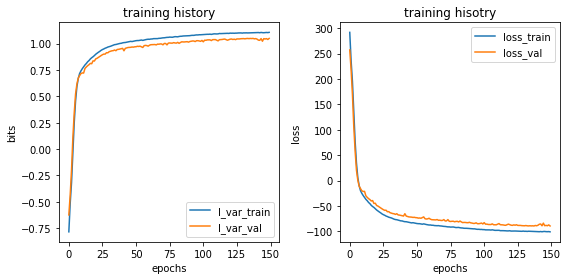

In [31]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_GE.history['I_var']
val_I_var_hist = model_GE.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training history')

ax = axs[1]
ax.plot(model_GE.history['loss'], label='loss_train')
ax.plot(model_GE.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [32]:
phi = gpmapGE.x_to_phi(x_test_GE)

In [33]:
WT_phi = gpmapGE.x_to_phi(model_GE.x_consensus)

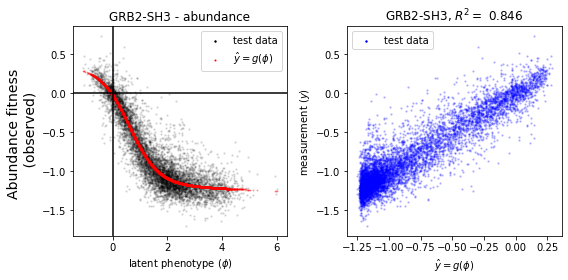

In [34]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

ax = axs[0]
yhat = mp_GE.phi_to_yhat(phi)
ax.scatter(-(phi-WT_phi)*3,y_test_GE,s=2,alpha=0.1,c='black',label='test data')
#ax.scatter(phi,yhat* model.y_std+model.y_mean,s=1,alpha=0.1,c='r',label='$\hat{y} = g(\phi)$')
ax.scatter(-(phi-WT_phi)*3,yhat,s=1,alpha=0.3,c='r',label='$\hat{y} = g(\phi)$')
ax.axvline(0,color='black')
ax.axhline(0,color='black')

ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('Abundance fitness \n (observed)',fontsize=14)
ax.set_title('GRB2-SH3 - abundance')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
ax = axs[1]
ax.scatter(yhat,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
Rsq = np.corrcoef(yhat.numpy().ravel(),y_test_GE)[0,1]**2

ax.set_xlabel('$\hat{y} = g(\phi)$')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'GRB2-SH3, $R^2 = $ {Rsq:.3f}')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/global_epistasis_binding_abundance.png',dpi=300,bbox_inches='tight')    

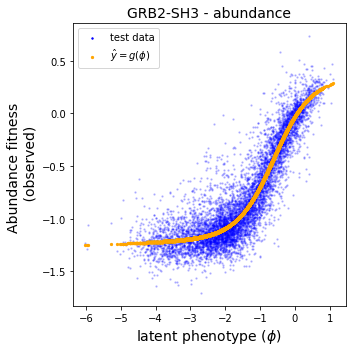

In [35]:
fig, axs = plt.subplots(1,1, figsize=(5,5))

ax = axs
yhat = mp_GE.phi_to_yhat(phi)
ax.scatter((phi-WT_phi)*3,y_test_GE,s=2,alpha=0.2,c='blue',label='test data')
#ax.scatter(phi,yhat* model.y_std+model.y_mean,s=1,alpha=0.1,c='r',label='$\hat{y} = g(\phi)$')
ax.scatter((phi-WT_phi)*3,yhat,s=5,alpha=1,c='orange',label='$\hat{y} = g(\phi)$')
# ax.axvline(0,color='black')
# ax.axhline(0,color='black')

ax.set_xlabel('latent phenotype ($\phi$)',fontsize=14)
ax.set_ylabel('Abundance fitness \n (observed)',fontsize=14)
ax.set_title('GRB2-SH3 - abundance',fontsize=14)
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/global_epistasis_binding_abundance.png',dpi=300,bbox_inches='tight')    

In [36]:
theta_lc_GE = gpmapGE.get_theta(model_GE,gauge='consensus')['theta_lc']

Text(0, 0.5, 'Theta global epistasis')

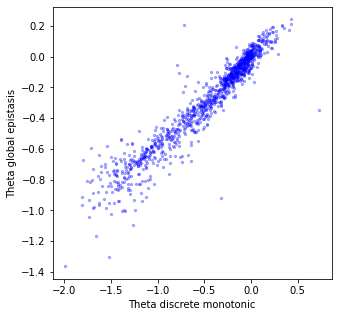

In [37]:
plt.figure(figsize=(5,5))
plt.scatter(theta_lc_DM.ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
plt.xlabel('Theta discrete monotonic')
plt.ylabel('Theta global epistasis')

In [38]:
lehner_abundance_singles_df = pd.read_csv('data/GRB2-SH3.singles_abundance.csv')
lehner_abundance_singles_df

,Unnamed: 0,Pos,WT_AA,Mut,nt_seq,aa_seq,Nham_nt,Nham_aa,Nmut_codons,STOP,STOP_readthrough,mean_count,fitness,sigma
0,1,1,T,N,NaN,NYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,3841.333333,0.005356,0.013882
1,2,1,T,K,NaN,KYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,8875.333333,0.043541,0.011053
2,3,2,Y,N,NaN,TNVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,10422.666667,-0.245382,0.010756
3,4,2,Y,K,NaN,TKVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,17328.333333,0.075076,0.009716
4,5,2,Y,T,NaN,TTVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,17210.333333,0.098840,0.007936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,1083,1,T,Y,NaN,YYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,3718.000000,0.011110,0.014031
1083,1084,1,T,*,NaN,*YVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,True,False,14937.666667,-0.579705,0.010358
1084,1085,1,T,C,NaN,CYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,6716.333333,0.022667,0.011817
1085,1086,1,T,W,NaN,WYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,NaN,1,1,False,False,11948.000000,-0.146080,0.010422


In [39]:
abundance_singles_transformed_df = pd.DataFrame(np.nan*np.ones(shape=(57,21)),columns=alphabet)
abundance_singles_transformed_df.head()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,*
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
for idx in lehner_abundance_singles_df.index:

    mutant = lehner_abundance_singles_df.loc[idx]['Mut']
    value = lehner_abundance_singles_df.loc[idx]['fitness']
    
    pos = lehner_abundance_singles_df.loc[idx]['Pos']-1
    abundance_singles_transformed_df[mutant][pos] = value



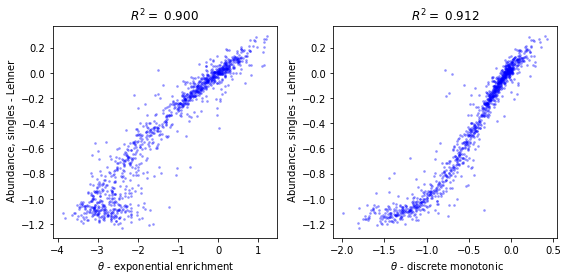

In [41]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
Rsq = np.corrcoef(theta_lc_consensus_EE_df.fillna(0).values.ravel(),abundance_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_lc_consensus_EE_df.values.ravel(),abundance_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - exponential enrichment')
ax.set_ylabel(' Abundance, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

ax = axs[1]
Rsq = np.corrcoef(theta_lc_consensus_DM_df.fillna(0).values.ravel(),abundance_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_lc_consensus_DM_df.values.ravel(),abundance_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - discrete monotonic')
ax.set_ylabel(' Abundance, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

fig.tight_layout()

fig.savefig('plots/GRB2_SH3/GRB2_SH3.singles_abundance_comparison_to_Lehner.png',dpi=200,bbox_inches='tight')


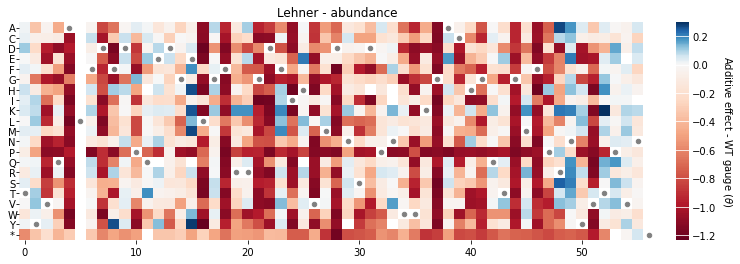

In [42]:
# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[12,4])

# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=abundance_singles_transformed_df.values,
                        alphabet=alphabet,
                        seq=model_abundance_DM.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Lehner - abundance')

fig.savefig('plots/GRB2_SH3/Lehner_GP_map_abundance.png',dpi=300,bbox_inches='tight')

In [43]:
data_df_GE.to_csv('abundance_lehner_GE.csv',index='False')

In [44]:
same_seq_data_df = pd.read_csv('same_seq_data.csv')
same_seq_data_df

,aa_seq,binding_fitness,abundance_fitness
0,NYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,0.028944,0.005356
1,KYVQALFDFEPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.114049,0.093083
2,KYVQALFDFDPQEDGELGFRRGDFIHAMDNSDPNWWKGACHGQTGM...,-0.604463,-1.048527
3,KYVQALFDFDPQEDGELGFRRGDFIHVKDNSDPNWWKGACHGQTGM...,-0.015866,-0.119053
4,KYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPN*WKGACHGQTGM...,-0.734009,-0.542546
...,...,...,...
5710,MYVQALFDFDPQEDGELGFRRGDVIHVMDNSDPNWWKGACHGQTGM...,0.084728,0.129528
5711,MYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,-0.419314,-1.154684
5712,MYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGM...,0.039077,0.037401
5713,MYVQALFDFDPQEDGELGFRRGDFIHVMDNSDANWWKGACHGQTGM...,-0.168129,-0.103582


In [45]:
same_abundance_phi = gpmapGE.x_to_phi(same_seq_data_df['aa_seq'].values)

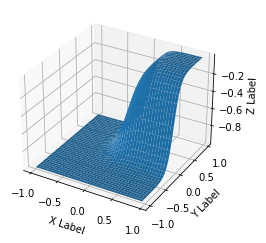

In [46]:
#np.savetxt('abundance_phi.txt',same_abundance_phi)

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random

def fun(x, y):
    return (1/(1+np.exp(-10*x)))*(1/(1+np.exp(-10*y)))-1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-1.0, 1.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

KeyError: 'abundance_phi'

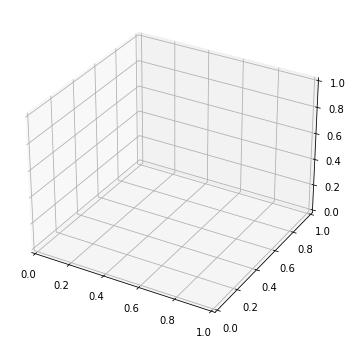

In [47]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
from matplotlib import cm
import random

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
x = same_seq_data_df['abundance_phi'].values
y = same_seq_data_df['binding_phi'].values
z = same_seq_data_df['abundance_fitness'].values
#z = same_seq_data_df['binding_fitness'].values
ax.scatter(x, y, z,color='blue',s=4,alpha=0.1,cmap = cm.coolwarm)
#ax.view_init(5, 5)
#ax.view_init(0, 0)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(True)
#ax.plot_surface(X, Y, Z,alpha=0.5)

ax.set_xlim(min(x),max(x))
ax.set_ylim(min(y),max(y))
ax.set_xticks([-1,-0.5,0,0.5])
ax.set_yticks([-1,-0.5,0,0.5])
ax.set_zticks([-1,-0.5,0,0.5])
ax.tick_params(labelsize=15)
ax.set_xlabel('Binding $\Delta \phi$ (inferred)',labelpad=15,fontsize=16)
ax.set_ylabel('Abundance $\Delta \phi$ \n (inferred)',labelpad=20,fontsize=16)
ax.set_zlabel('Binding fitness \n (observed)',labelpad=15,fontsize=16)
fig.tight_layout()
fig.savefig('3d_scatter_lehner.png',dpi=300,bbox_inches='tight')

In [ ]:
temp_x = np.arange(-1,1,0.1)
plt.scatter(temp_x,1/(1+np.exp(-10*temp_x)))
#plt.scatter(temp_x,1/(1+4*np.exp(-temp_x)))